# **Import Statements**

In [1]:
'''
Import Statements for Photon Data Analysis
'''
import tensorflow as tf
import numpy as np
import matplotlib, scipy
from numba import jit
from matplotlib import pyplot as plt
from scipy.optimize import minimize, curve_fit
#from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
#from scipy.interpolate import InterpolatedUnivariateSpline
#from scipy import constants
from skimage.util.shape import view_as_windows
from scipy.stats import gaussian_kde
from collections import deque
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects

#suppress annoying tensorflow warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


print("Tensorflow Version: " +  tf.__version__)
print("Numpy Version: "  + np.__version__)
print("Matplotlib Version: " + matplotlib.__version__)
print("Scipy Version: " + scipy.__version__)




'''
Import Statements for MKID noiseanalysis
'''
import logging

import matplotlib.pyplot as plt

from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidreadout import MKIDReadout
from mkidreadoutanalysis.optimal_filters.make_filters import Calculator
#from mkidcore.config import ConfigThing 
#^^Need to ask Jenny if this matters
import copy

Tensorflow Version: 2.9.2
Numpy Version: 1.23.4
Matplotlib Version: 3.6.2
Scipy Version: 1.9.3


# **Quasiparticle Synthetic Data Generation**

**Synthetic Data Generation Function**

In [2]:
def synthetic_data_gen(wl, fs, ts):
    '''
    Generate synthetic data time stream using the mkidreadoutanalysis library

    Inputs: 
    -wl: list with float/int elements, allowed (discrete) photon wavelengths in nanometers [nm]
    -fs: float with the sample rate of the timestream
    -ts: float with the total time for the timestream
    '''

    #Generating Quasiparticle Timestream and populating it with photons
    quasiparticle_timestream = QuasiparticleTimeStream(wl = wl, fs = fs, ts = ts, seed=None)
    quasiparticle_timestream.gen_quasiparticle_pulse(tf = 30)
    photon_arrivals = quasiparticle_timestream.gen_photon_arrivals(cps=500)
    quasiparticle_timestream.populate_photons(tf = 30)

    #Creating a resonator object
    resonator = Resonator(f0=4.0012e9, qi=200000, qc=15000, xa=1e-9, a=0, tls_scale=1e2)
    rf = RFElectronics(gain=(3.0, 0, 0), phase_delay=0, cable_delay=50e-9)
    freq = FrequencyGrid( fc=4.0012e9, points=1000, span=500e6)
    sweep = ResonatorSweep(resonator, freq, rf)

    #Creating Photon Resonator Readout
    lit_res_measurment = ReadoutPhotonResonator(resonator, quasiparticle_timestream, freq, rf)
    lit_res_measurment.noise_on = True #toggle white noise and line noise
    lit_res_measurment.rf.noise_scale = 10 #adjust white noise scale

    #configure line noise for Resonator
    lit_res_measurment.rf.line_noise.freqs = ([60, 50e3, 100e3, 250e3, -300e3, 300e3, 500e3]) # Hz and relative to center of bin (MKID we are reading out)
    lit_res_measurment.rf.line_noise.amplitudes = ([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.01])
    lit_res_measurment.rf.line_noise.phases = ([0, 0.5, 0,1.3,0.5, 0.2, 2.4])

    #Generating Synthetic Data for Output
    I = lit_res_measurment.iq_response.real
    Q = lit_res_measurment.iq_response.imag

    return I, Q, quasiparticle_timestream, photon_arrivals




**Example Usage**

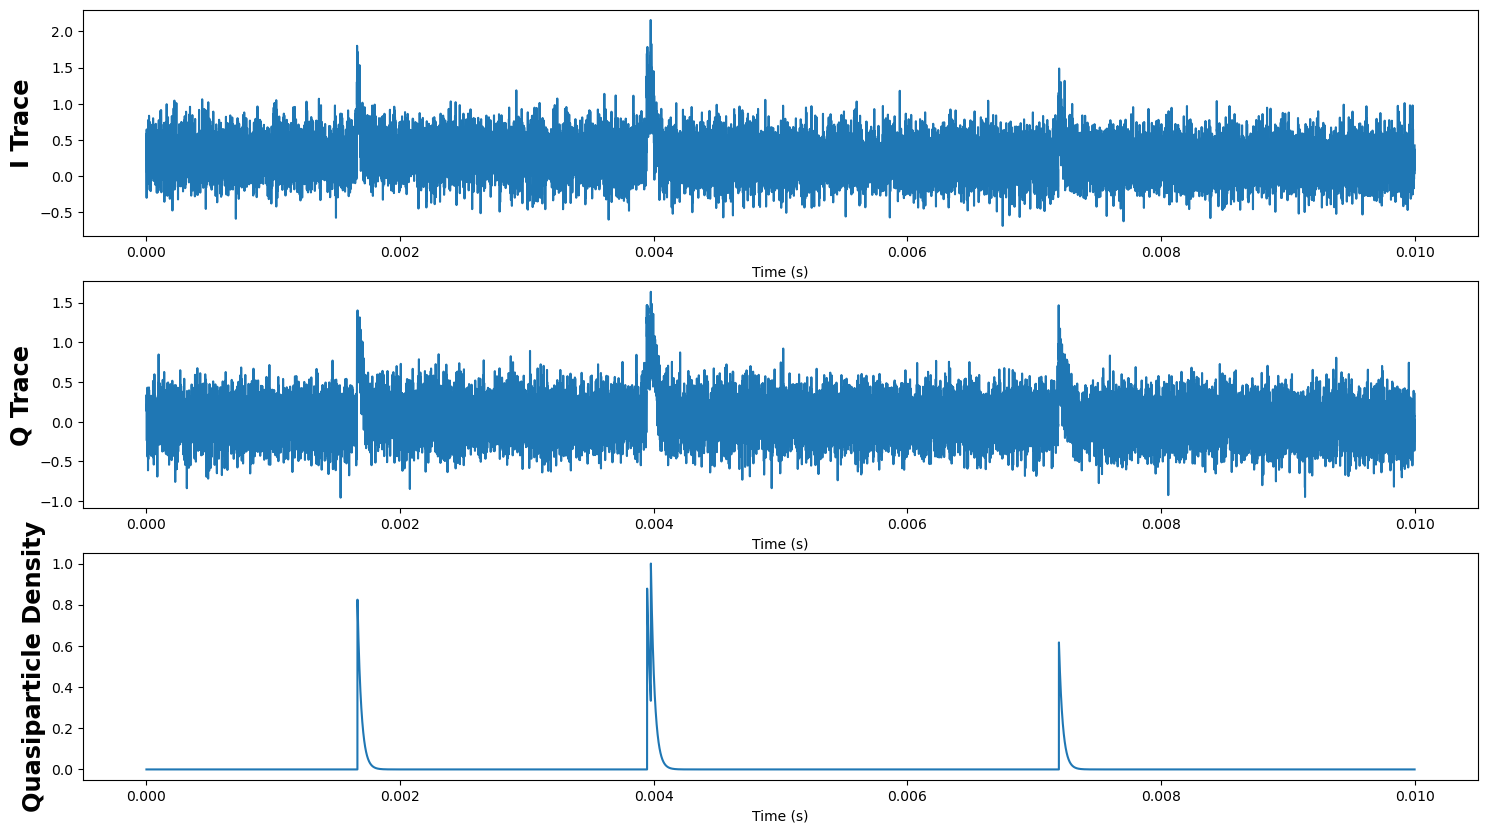

In [3]:
wl = [808, 920, 980, 1120, 1310]
fs = 2e6
ts = 0.01

#Generate Data
I, Q, quasiparticle_timestream, photon_arrivals = synthetic_data_gen(wl, fs, ts)
label = quasiparticle_timestream.data
tvec = quasiparticle_timestream.tvec


#Plot Data
fig, ax = plt.subplots(3,1,figsize = (18,10))

ax[0].plot(tvec, I)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("I Trace",fontweight = "bold", size = 'xx-large')

ax[1].plot(tvec, Q)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Q Trace",fontweight = "bold", size = 'xx-large')

ax[2].plot(tvec, label)
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("Quasiparticle Density",fontweight = "bold", size = 'xx-large')

plt.show()




# **Model Training**
Run these cells if you are training a new model!

**Data Processing**

In [4]:
def normalize(data):
  mean = np.mean(data)
  std = np.std(data)
  return (data-mean)/(std)

def make_Dataset(batch_size, window_shape, I, Q, label = None):
    #only normalize the input data so the target output doesn't get warped, and create rolling windows
    I = view_as_windows(normalize(I), window_shape)
    Q = view_as_windows(normalize(Q),window_shape)

    #creating windows for the data
    data_windows = tf.convert_to_tensor(np.stack((I,Q), axis = -1), dtype = tf.float32)

    #using optional argument to build Datasets with/without labels & time if they are/aren't passed
    if label is None:
        dataset = tf.data.Dataset.from_tensor_slices(data_windows)
    else:
        #converting label to tensor
        energy_label = tf.convert_to_tensor(label[int(window_shape/2):-int(window_shape/2)], dtype = tf.float32)

        #constructing dataset tuple
        dataset = tf.data.Dataset.from_tensor_slices((data_windows, energy_label))
    
    #batching datasets
    dataset = dataset.batch(batch_size)

    return dataset
    

#defining hyperparameters for the ML
batch_size = 100       # How many values before the model updates parameters and checks against the validation set
window_shape = 149     # MUST BE AN ODD NUMBER OR THE ROLLING WINDOW WILL NOT BE SYMMETRIC AND THERE WILL BE PROBLEMS
vector_size = 2        # This indicates the dimension of inputs to the model (currently dimensions of [I, Q])

#defining hyperparameters for the quasiparticle timestream
SampRate = 2e6         # Sample rate is 2 MHz
TrainingTime = 0.2     # Training data set length in sec



#Training Dataset
train_wl = [825, 875, 925, 975, 1025, 1075, 1125, 1175, 1225, 1275, 1325] #Wavelengths to train on
i_train, q_train, quasiparticle_train, _ = synthetic_data_gen(train_wl, SampRate, TrainingTime)
dataset_train = make_Dataset(batch_size, window_shape, i_train, q_train, quasiparticle_train.data)


#Validation Dataset
val_wl = [850, 950, 1050, 1150, 1250] #Wavelength(s) to generate a validation set from
i_val, q_val, quasiparticle_val, _ = synthetic_data_gen(val_wl, SampRate, TrainingTime)
dataset_val = make_Dataset(batch_size, window_shape, i_val, q_val, quasiparticle_val.data)

**Blank Model Creation**

In [5]:
implicit_input_shape = (window_shape, vector_size)

#create the energy prediction
model = tf.keras.Sequential(
[
    #Input Layer
    tf.keras.Input(shape = implicit_input_shape),
        
    #Convolutional Network  
    tf.keras.layers.Conv1D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
    tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', data_format = 'channels_last'),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
    tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', data_format = 'channels_last'),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
    tf.keras.layers.MaxPooling1D(pool_size = 5, padding = 'same', data_format = 'channels_last'),
        
        
    #LSTM Network
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
     
    #Dense Layer
    tf.keras.layers.Dense(32, activation = 'relu'),

    #Output Layer + Flattening
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
    ])
  
    
#compile the model with the optimizer
model.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.MeanSquaredError()
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 149, 128)          1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 75, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 38, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 32)            10272     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 32)            0

**Training Model**

In [7]:
#model_checkpoint and early stopping callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("saved_model.h5", save_best_only=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5*10**(epoch/10)) #figure out optimal learning rate 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 2)

#relevant hyperparameter
epochs = 100

#fit model
history = model.fit(dataset_train, epochs=epochs,validation_data=dataset_val, callbacks=[model_checkpoint, lr_schedule, early_stopping])
np.save("my_history.npy", history.history)

Epoch 1/100
3999/3999 [==============================] - 719s 180ms/step - loss: 0.0016 - val_loss: 7.9961e-04 - lr: 1.0000e-05
Epoch 2/100
3999/3999 [==============================] - 507s 127ms/step - loss: 8.2091e-04 - val_loss: 5.5700e-04 - lr: 1.2589e-05
Epoch 3/100
3999/3999 [==============================] - 511s 128ms/step - loss: 5.5877e-04 - val_loss: 3.4161e-04 - lr: 1.5849e-05
Epoch 4/100
3999/3999 [==============================] - 512s 128ms/step - loss: 3.3218e-04 - val_loss: 1.8377e-04 - lr: 1.9953e-05
Epoch 5/100
3999/3999 [==============================] - 525s 131ms/step - loss: 2.2464e-04 - val_loss: 1.2397e-04 - lr: 2.5119e-05
Epoch 6/100
3999/3999 [==============================] - 535s 134ms/step - loss: 1.9370e-04 - val_loss: 1.0809e-04 - lr: 3.1623e-05
Epoch 7/100
3999/3999 [==============================] - 554s 138ms/step - loss: 1.9658e-04 - val_loss: 1.0016e-04 - lr: 3.9811e-05
Epoch 8/100
3999/3999 [==============================] - 538s 135ms/step - loss:

**Training Metrics**

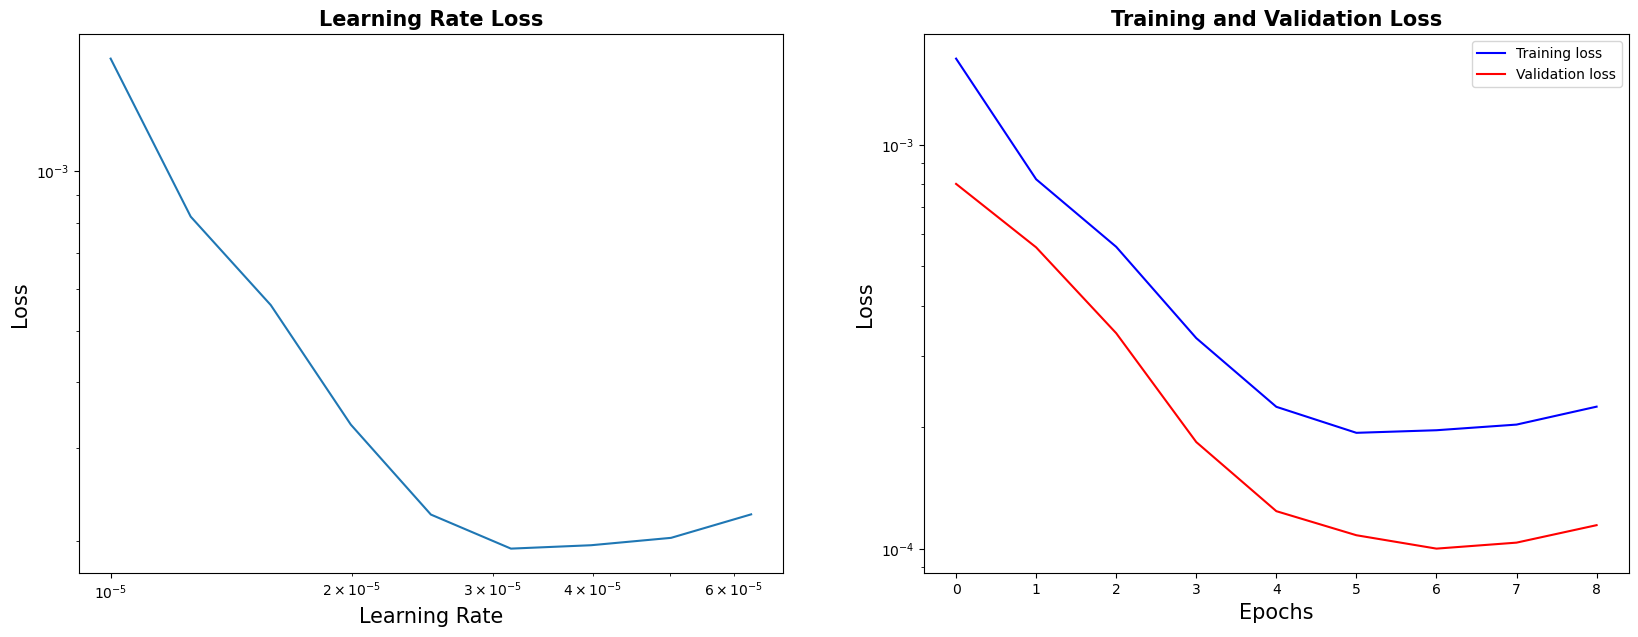

In [8]:
fig, ax = plt.subplots(1,2, figsize = (20,7))


#display Loss as a function of Learning Rate
ax[0].loglog(history.history["lr"], history.history["loss"])
ax[0].set_xlabel("Learning Rate", fontsize = 15)
ax[0].set_title("Learning Rate Loss", fontsize = 15, fontweight = 'bold')
ax[0].set_ylabel("Loss", fontsize = 15)


#Display Loss as a function of epochs
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
ax[1].semilogy(epochs, loss, c="b", label="Training loss")
ax[1].semilogy(epochs, val_loss,c="r", label="Validation loss")
ax[1].set_title("Training and Validation Loss", fontsize = 15, fontweight = 'bold')
ax[1].set_xlabel("Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].legend()
plt.show()

# **Model Loading**
Run these cells if you are loading an already existing model!

**Hyperparameters** <br>
Port hyperparameters used in training the model

In [ ]:
window_shape = 149 #This hyperparameter describes the hyperrectangle for the rolling window view
batch_size = 100 #This hyperparameter describes how many Dataset slices the model will look at before adjusting model parameters
vector_size = 2 #this indicates the dimension of inputs to the model (currently dimensions of [I, Q])
SampRate = 2e6     # Sample rate is 2 MHz
train_wl = [825, 875, 925, 975, 1025, 1075, 1125, 1175, 1225, 1275, 1325] #Wavelengths to train on
val_wl = [850, 950, 1050, 1150, 1250] #Wavelength(s) to generate a validation set from



#Need to define the following functions to load data into the model in the same way in which it was trained
def normalize(data):
  mean = np.mean(data)
  std = np.std(data)
  return (data-mean)/(std)

def make_Dataset(batch_size, window_shape, I, Q, label = None):
    #only normalize the input data so the target output doesn't get warped, and create rolling windows
    I = view_as_windows(normalize(I), window_shape)
    Q = view_as_windows(normalize(Q),window_shape)

    #creating windows for the data
    data_windows = tf.convert_to_tensor(np.stack((I,Q), axis = -1), dtype = tf.float32)

    #using optional argument to build Datasets with/without labels & time if they are/aren't passed
    if label is None:
        dataset = tf.data.Dataset.from_tensor_slices(data_windows)
    else:
        #converting label to tensor
        energy_label = tf.convert_to_tensor(label[int(window_shape/2):-int(window_shape/2)], dtype = tf.float32)

        #constructing dataset tuple
        dataset = tf.data.Dataset.from_tensor_slices((data_windows, energy_label))
    
    #batching datasets
    dataset = dataset.batch(batch_size)

    return dataset


**Loading Model**

In [ ]:
model = tf.keras.models.load_model("saved_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 149, 128)          1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 75, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 38, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 32)            10272     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 32)            0

**Displaying Training Metrics**

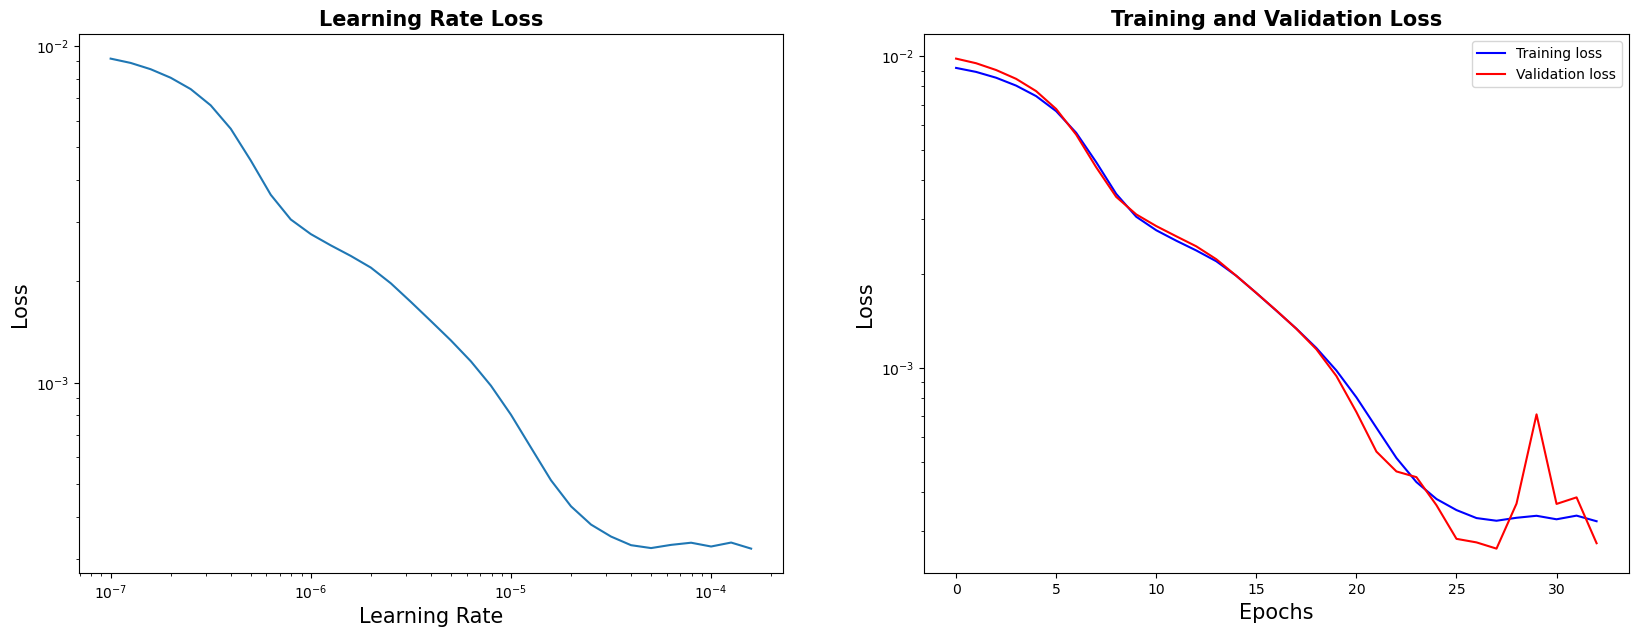

In [ ]:
history = np.load("my_history.npy", allow_pickle = True).item()
fig, ax = plt.subplots(1,2, figsize = (20,7))


#display Loss as a function of Learning Rate
ax[0].loglog(history["lr"], history["loss"])
ax[0].set_xlabel("Learning Rate", fontsize = 15)
ax[0].set_title("Learning Rate Loss", fontsize = 15, fontweight = 'bold')
ax[0].set_ylabel("Loss", fontsize = 15)


#Display Loss as a function of epochs
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(len(loss))
ax[1].semilogy(epochs, loss, c="b", label="Training loss")
ax[1].semilogy(epochs, val_loss,c="r", label="Validation loss")
ax[1].set_title("Training and Validation Loss", fontsize = 15, fontweight = 'bold')
ax[1].set_xlabel("Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].legend()
plt.show()

# **Model Evaluation**

**Defining `model_predictions` Function**<br>
The `model_predictions` function generates evaluation data using the `synthetic_data_gen` function defined under the **Data Generation** heading. It then generates and returns model predictions based on the evaluation data generated in the function call. 

In [9]:
def model_predictions(model, wl, fs, ts, return_labels = bool):
    #Need to create the evaluation data the same way as the training data, using previously defined functions
    i_eval, q_eval, quasiparticle_eval, arrival_eval = synthetic_data_gen(wl, fs, ts)
    dataset_eval = make_Dataset(batch_size, window_shape, i_eval, q_eval, quasiparticle_eval.data)

    #Generating Model Predictions
    output = model.predict(dataset_eval)

    #the 1 dimensional model prediction 
    model_prediction = np.squeeze(output)

    #packaging photon arrival information and quasiparticle density into one label
    arrival_indices = np.where(arrival_eval == True)[0] #converts from boolean list to indices of peaks
    label_eval = (arrival_indices, quasiparticle_eval.data)

    if return_labels == True:
        return model_prediction, label_eval
    elif return_labels == False:
        return model_prediction      

**Generating a Rescaling Factor**<br>
Model predictions need to be rescaled by a constant factor in order to be compared to label peaks. This `rescaling_factor` can be estimated by eye, but ideally, we want to determine the rescaling factor quantitatively for any set of data that the model might be asked to make predictions upon. In the next code cell, we generate evaluation data and minimize the `scaling_factor` function(which returns the least squares difference between the model's predicted peaks and the label's peaks) to obtain the best fit `rescaling_factor`. We then perform bootstrap resampling by redoing the previous step multiple times in order to recover a bootstrapped `rescaling_factor` and it's uncertainty. This bootstrapped resampled `rescaling_factor` can then be applied to all predictions made by the model. Expect this cell to take around 10 minutes to run with 50 iterations.

In [10]:
  temporal_shift_range = 250 #The number of values on either side of label peaks we will look for a temporally shifted peak

#Defining the function to minimize to obtain the scaling factor for each generated evaluation dataset
def scaling_factor(rescaling_factor, model_prediction, label_eval):
    #when the label does not equal zero, a photon is incident
    arrival_eval, energy_eval = label_eval
    lstsq = 0


    #We want to determine the appropriate scaling factor by minimizing the least squares difference of the model predictions and label values for photon energy
    for arrival in arrival_eval:
        #Error protection if photon arrives before temporal shift range
        if arrival < temporal_shift_range:
            continue

        label_peak = energy_eval[arrival]
        prediction_range = model_prediction[arrival - temporal_shift_range: arrival + temporal_shift_range]
        model_peak = max(prediction_range) #pick the maximum value in the prediction because that's where the quasiparticle density peaks
        lstsq += (model_peak*rescaling_factor - label_peak)**2 #calculate lstsq value(to be minimized)

    return lstsq

#Passing the scaling_factor function to the minimizing function
def find_best_rescaling_factor(model_prediction, label_eval):
    guess = np.random.rand() #Since we are only fitting one parameter, our initial guess shouldn't matter
    rescaling_factor = minimize(scaling_factor, guess, args=(model_prediction, label_eval), method = "Powell").x
    return rescaling_factor

#Defining the function to minimize to obtain the temporal shift factor for each generated evaluation dataset
def find_best_temporal_shift(model_prediction, label_eval):
    #when the label does not equal zero, a photon is incident
    arrival_eval, energy_eval = label_eval
    temporal_shift = []

    #We want to determine the appropriate temporal shift by averaging all the temporal shifts over the entire model
    for arrival in arrival_eval:
        #Error protection if photon arrives before temporal shift range
        if arrival < temporal_shift_range:
            continue

        label_peak = energy_eval[arrival]
        prediction_range = model_prediction[arrival - temporal_shift_range: arrival + temporal_shift_range]
        temporal_shift.append(np.squeeze(np.asarray(np.where(prediction_range == min(prediction_range)))) - len(prediction_range)/2)

    #calculating statistics
    temporal_shift = np.asarray(temporal_shift)
    avg_temporal_shift = np.mean(temporal_shift)
    sigma_temporal_shift = np.std(temporal_shift)

    return avg_temporal_shift, sigma_temporal_shift

eval_TrainingTime = 0.015 #even if training the model on more than 0.015 second of training time, evaluate it on 0.015 second of training time because it's faster
N_time_datapoints = int(SampRate*eval_TrainingTime)
time_eval = np.linspace(0,eval_TrainingTime,N_time_datapoints)

#Performing bootstrap resampling: When generating synthetic data with a training time of 0.01 seconds, model_predictions took about 10 seconds per iteration(expect this cell to be computationally expensive)
num_iter = 10
bstrap_rescaling_list = deque()
bstrap_temporal_avg_list = deque()
bstrap_temporal_sigma_list = deque()
for i in range(num_iter):
    bstrap_model_prediction, bstrap_label = model_predictions(model, train_wl, SampRate, eval_TrainingTime, return_labels = True)

    #if there are no photon peaks, skip to the next iteration to avoid erroring out
    if len(bstrap_label[0]) == 0:
      continue
    
    #bstrapping rescaling factor
    rescaling_factor_i = find_best_rescaling_factor(bstrap_model_prediction, bstrap_label)
    bstrap_rescaling_list.append(rescaling_factor_i)

    #bstrapping temporal shift
    avg_temporal_shift_i, sigma_temporal_shift_i  = find_best_temporal_shift(bstrap_model_prediction, bstrap_label)
    bstrap_temporal_avg_list.append(avg_temporal_shift_i)
    bstrap_temporal_sigma_list.append(sigma_temporal_shift_i)

#Rescaling Factor
bstrap_rescaling_factor = np.mean(bstrap_rescaling_list)
sigma_rescaling_factor = np.std(bstrap_rescaling_list)
print(f"Using bootstrap resampling with {num_iter} iterations generates a rescaling factor of {bstrap_rescaling_factor:.3f} ± {sigma_rescaling_factor:.3f}")

#Temporal Shift
bstrap_temporal_shift = np.mean(bstrap_temporal_avg_list)
sigma_temporal_shift = np.mean(bstrap_temporal_sigma_list)
print(f"Using bootstrap resampling with {num_iter} iterations generates a temporal shift of {bstrap_temporal_shift:.3f} ± {sigma_temporal_shift:.3f}")

299/299 [==============================] - 14s 46ms/step
Using bootstrap resampling with 10 iterations generates a rescaling factor of 1.126 ± 0.026
Using bootstrap resampling with 10 iterations generates a temporal shift of -86.740 ± 34.717


A small range of rescaling factors from multiple iterations of model predictions on randomly created evaluation data during bootstrapping implies that the model is consistently 'off' the true values by roughly the same amount. This corresponds to the uncertainty on the bootstrap resampled rescaling factor, which therefore gives an indication of how precise (and therefore how good) the model is.

**Model Prediction + Scaling Factor Generation**

In [18]:
prediction, label_eval = model_predictions(model, train_wl, SampRate, eval_TrainingTime, return_labels = True)
best_rescaling_factor = find_best_rescaling_factor(prediction, label_eval)
arrival_eval, energy_eval = label_eval

299/299 [==============================] - 19s 64ms/step


**Prediction Visualization**

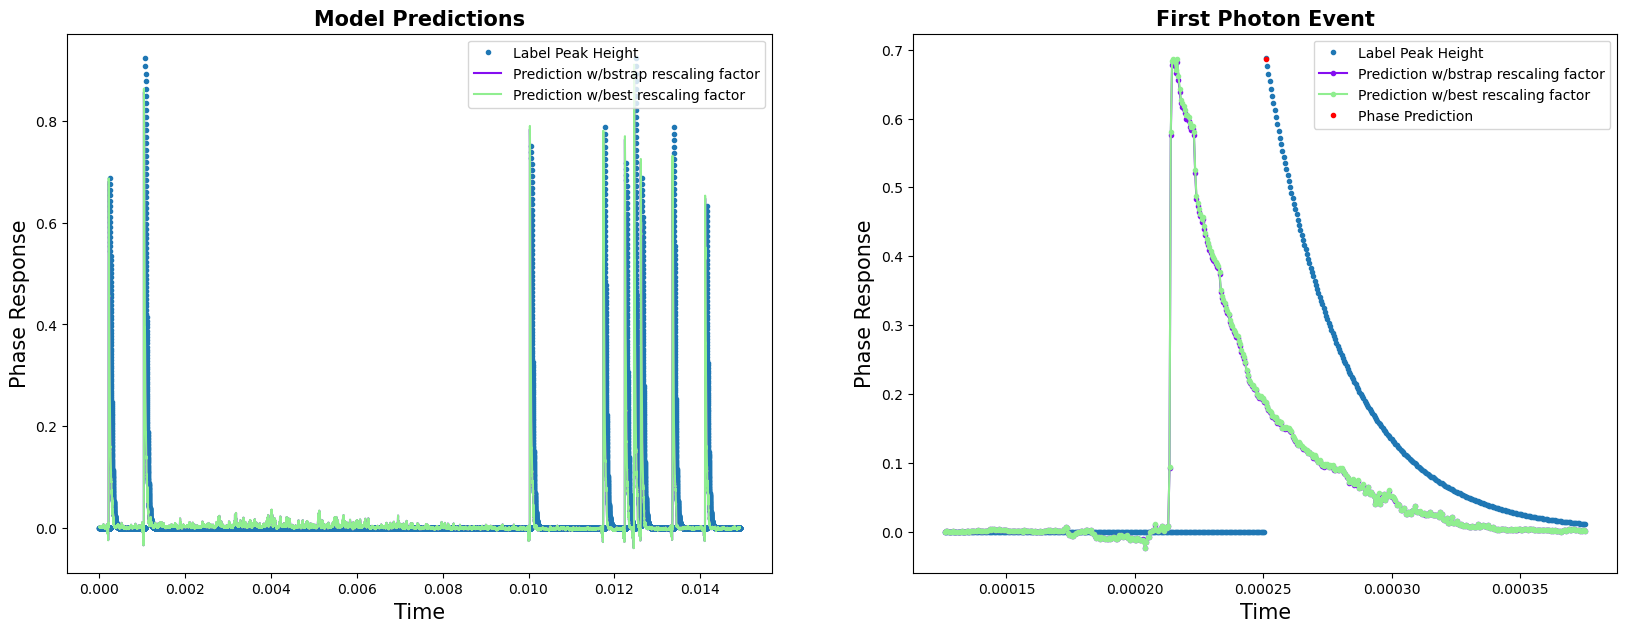

In [19]:
fig, ax = plt.subplots(1,2, figsize = (20,7))

#Plotting Model Predictions
ax[0].plot(time_eval[0:N_time_datapoints - window_shape],energy_eval[0:N_time_datapoints - window_shape],label = "Label Peak Height", linestyle = '', marker= '.')
ax[0].plot(time_eval[0:N_time_datapoints - window_shape],prediction[0:N_time_datapoints - window_shape]*bstrap_rescaling_factor,label = "Prediction w/bstrap rescaling factor", c = '#850ef0')
ax[0].plot(time_eval[0:N_time_datapoints - window_shape],prediction[0:N_time_datapoints - window_shape]*best_rescaling_factor,label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[0].set_ylabel("Phase Response", fontsize = 15)
ax[0].set_xlabel("Time", fontsize = 15)
ax[0].set_title("Model Predictions", fontweight = 'bold', fontsize = 15)
ax[0].legend(loc = 'upper right')

#Zooming in on the first Photon Detection
first_photon = arrival_eval[0] #gets index of first photon detection
nearest_peak = max(prediction[first_photon - temporal_shift_range: first_photon + temporal_shift_range]) #gets value of the nearest peak
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],energy_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],label = "Label Peak Height", linestyle = '', marker= '.')
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],prediction[first_photon - temporal_shift_range:first_photon + temporal_shift_range]*bstrap_rescaling_factor,marker = '.',label = "Prediction w/bstrap rescaling factor",c = '#850ef0')
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],prediction[first_photon - temporal_shift_range:first_photon + temporal_shift_range]*best_rescaling_factor,marker = '.',label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[1].plot(time_eval[first_photon], nearest_peak*best_rescaling_factor, label = "Phase Prediction", linestyle = '', marker = '.', color = 'red')
ax[1].set_ylabel("Phase Response", fontsize = 15)
ax[1].set_xlabel("Time", fontsize = 15)
ax[1].set_title("First Photon Event", fontweight = 'bold', fontsize = 15)
ax[1].legend()

plt.show()


# **Spectra and Curve Fitting**

**Energy Histogram Functions** <br>
Generating the histogram of energies from the label and the predictions from the model, based on an arbitrary input spectra. If they are indistinguishable, it implies that the machine learning model is an appropriate tool for data analysis for this system.

In [13]:
def gen_hist_data (wl, fs, ts):
    #For reasons I don't fully understand, joblib struggles with naming conflicts if you make function calls to other functions that have objects with identical names (or something)
    #After a lot of trial and error but mostly error, I took the contents of the model_predictions function (defined above), and copy + pasted it here. It works. Don't question it.
    #Need to create the evaluation data the same way as the training data, using previously defined functions
    
    i_eval, q_eval, quasiparticle_eval, arrival_eval = synthetic_data_gen([wl], fs, ts)
    dataset_eval = make_Dataset(batch_size, window_shape, i_eval, q_eval, quasiparticle_eval.data)

    #Generating Model Predictions
    output = model.predict(dataset_eval)

    #the 1 dimensional model prediction 
    prediction = np.squeeze(output)

    #packaging photon arrival information and quasiparticle density into one label
    arrival_indices = np.where(arrival_eval == True)[0] #converts from boolean list to indices of peaks
    label_eval = (arrival_indices, quasiparticle_eval.data)

    #####################################################################
    #everything above this comment is from the model_predictions function
    arrival_indices, true_energy = label_eval

    #acquiring peak values from the label
    true_peaks = []
    for arrival in arrival_indices:
        peak = true_energy[arrival]
        true_peaks.append(peak)
    true_peaks = np.asarray(true_peaks)

    #acquiring peak values from the prediction
    prediction = prediction*bstrap_rescaling_factor
    pred_indices, max = find_peaks(prediction,height = 0.2 ,distance = temporal_shift_range) 
    pred_peaks = np.asarray(max['peak_heights']) #find_peaks creates an array with peak_indices and a dictionary with peak_heights as a key

    return true_peaks, pred_peaks

#Choose wavelengths for which to make data and generate predictions
def spectrum_hist(wl, fs = 2000000, ts = 0.5, parallel = bool):

    if parallel == False: 
        hist_data = [gen_hist_data(wl, fs, ts) for i in range(5)] #generate 2.5 seconds worth of data (with default time set)
            
    elif parallel == True: 
        hist_data = Parallel(n_jobs = -1, verbose = 10)(delayed(gen_hist_data)(wl,fs,ts) for i in range(20)) #Generates 10 seconds worth of data (quickly) but bricks my laptop

    #unpacking values
    true_peaks_hist = []
    pred_peaks_hist = []
    for process in hist_data:
        true_peaks, pred_peaks = process
        true_peaks_hist.extend(list(true_peaks))
        pred_peaks_hist.extend(list(pred_peaks))

    return true_peaks_hist, pred_peaks_hist


**Transformation from Phase Space to Electron Volts** <br>
Using Planck's formula, we can transform from quasiparticle density to wavelength to electron volts.
$$\begin{align}
Q &= \frac{Q_0}{\lambda} \\
E &= \frac{h \cdot c}{\lambda} \\
E &= \frac{h \cdot c}{Q_0} Q
\end{align}$$

In [14]:
@np.vectorize 
def quasi_to_ev(Q):
    #hc = 1.24e3 in eV, from https://www.sciencedirect.com/topics/engineering/plancks-constant
    #current quasiparticle density code has Q_0 set to 808 nm
    return 1.24e3/808 * Q

**Energy Resolution Calculation Function**

In [15]:
def E_resolution(spectra, n_bins = 200):
    density, bins = np.histogram(spectra, bins = n_bins, density = True)
    x = bins[0:-1] - 0.5*(bins[1]-bins[0])

    #return the corresponding pdf
    kernel = gaussian_kde(spectra)
    pdf = kernel(x)

    #Get the mean, FWHM, and Energy Resolution from the KDE fit to the histogram
    mu = x[np.where(pdf == max(pdf))]
    HM = max(pdf)/2
    HM_indices = np.where(np.diff(np.sign(pdf - HM)))[0]
    left_bound = np.where(np.diff(np.sign(x[HM_indices] - mu*np.ones(len(HM_indices)))))[0][0]
    FWHM = np.abs(x[HM_indices[left_bound]] - x[HM_indices[left_bound+1]])
    R = mu/FWHM

    return x, pdf, mu, R


**Model Prediction Histogram Generation**

In [16]:
eval_wl = [900,1000,1100,1200,1300] #evaluate on the following wavelengths

eval_dict_storage = []
for wl in eval_wl:
    #Generating and Converting Data
    true_peaks, pred_peaks = spectrum_hist(wl, parallel = False)
    pred_eV = quasi_to_ev(pred_peaks)

    #Fitting to Histograms
    pred_x, pred_pdf, _, pred_R = E_resolution(pred_eV)
    

    fname_dict = {
        'pred_hist': pred_eV, 
        'plot_pred_x': pred_x,
        'plot_pred_pdf': pred_pdf,
        'pred_E_Res': pred_R,
        'wavelength': wl
    }

    eval_dict_storage.append(fname_dict)


9999/9999 [==============================] - 308s 31ms/step


More than 1 photon arriving per time step. Lower the count rate?


9999/9999 [==============================] - 317s 32ms/step


More than 1 photon arriving per time step. Lower the count rate?


9999/9999 [==============================] - 463s 46ms/step


**Visualizing Histograms**

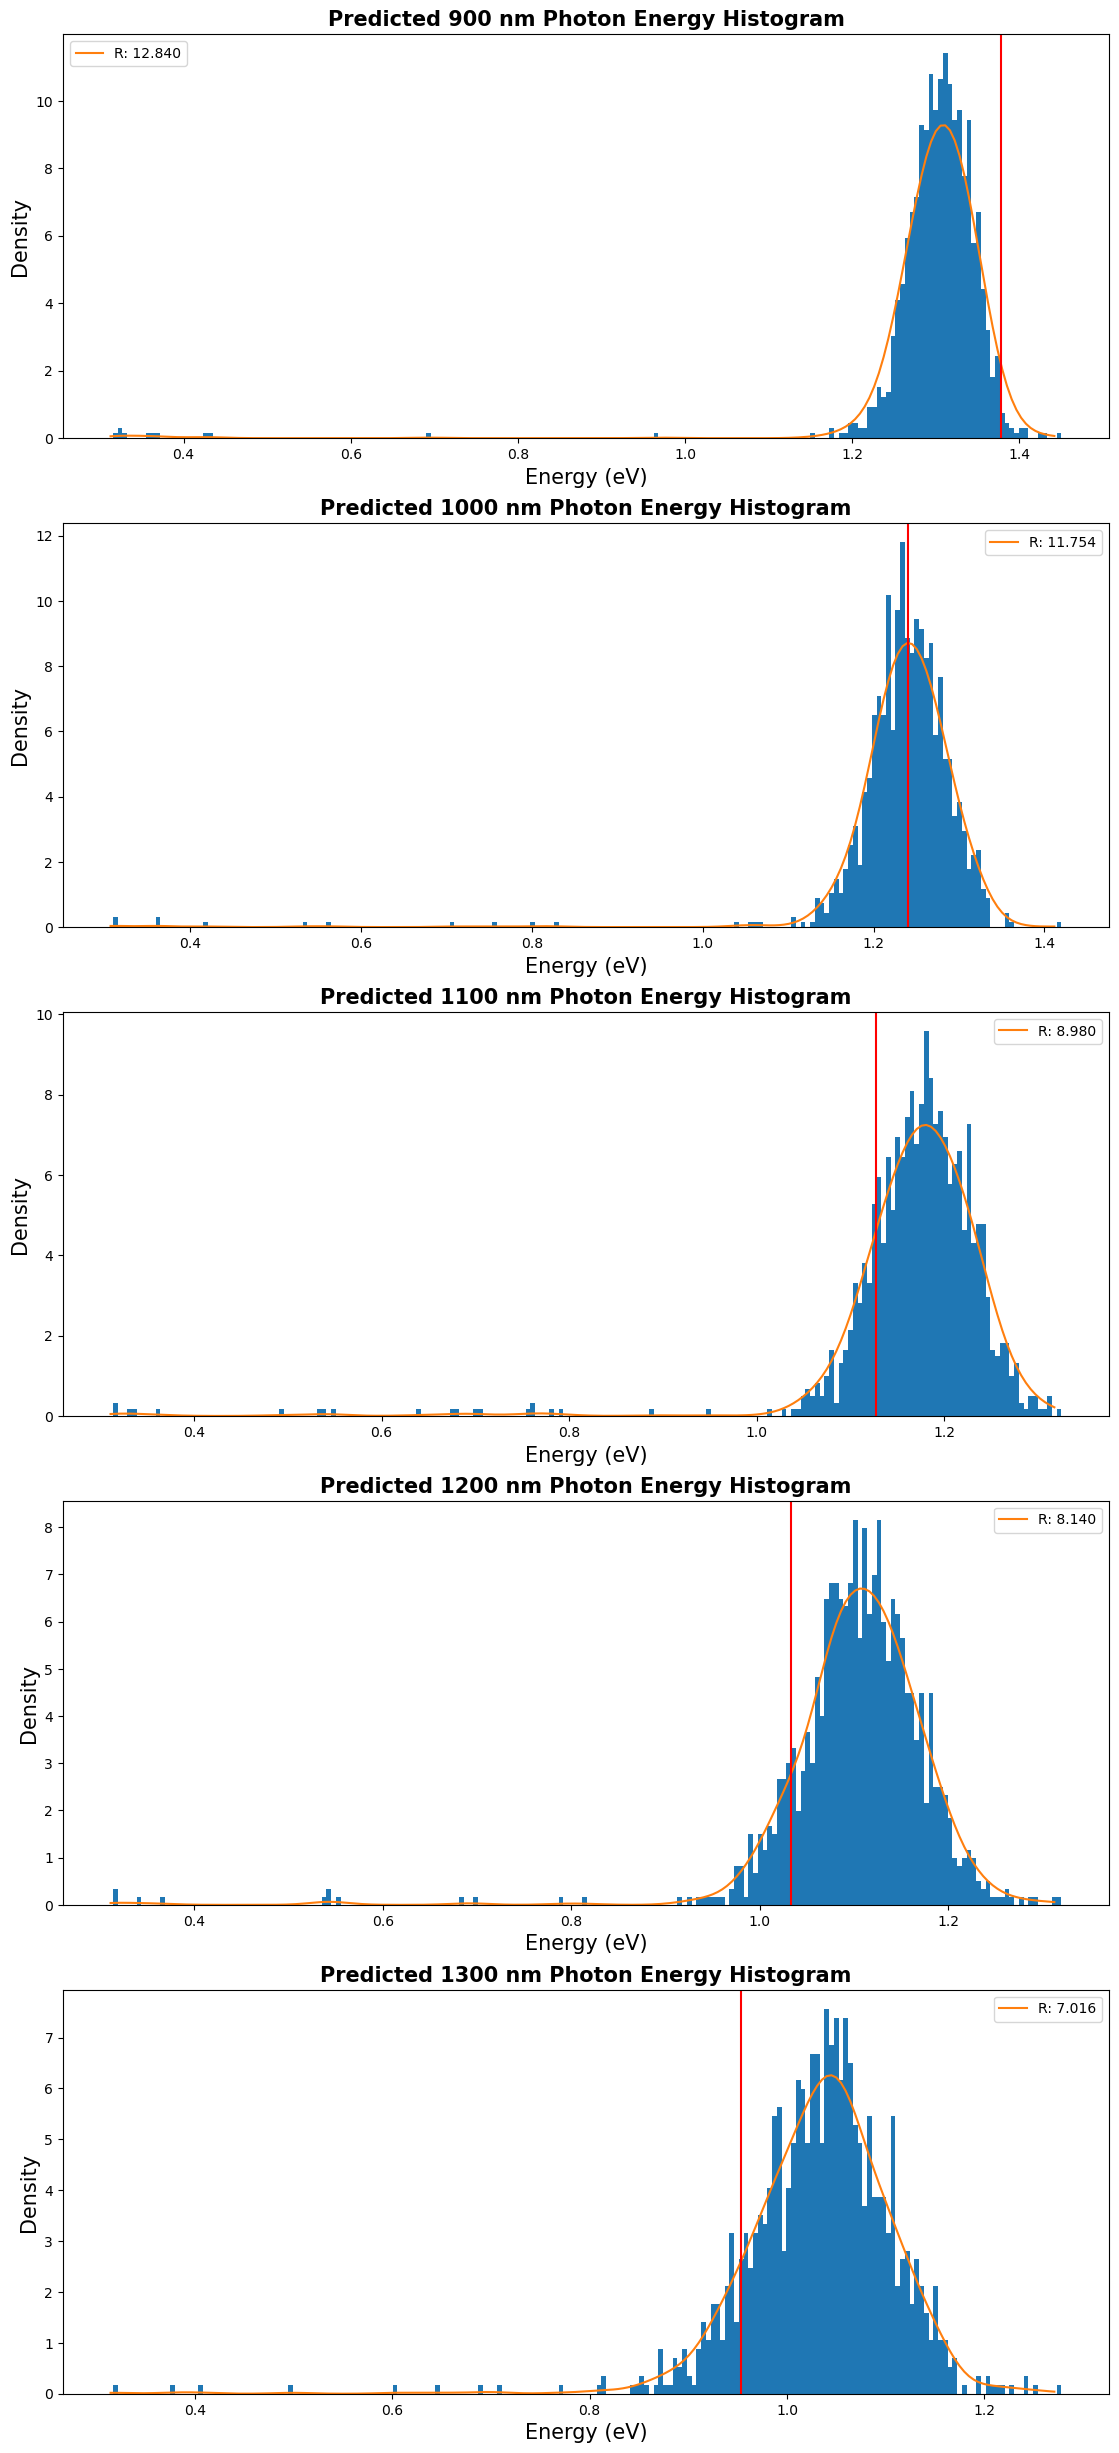

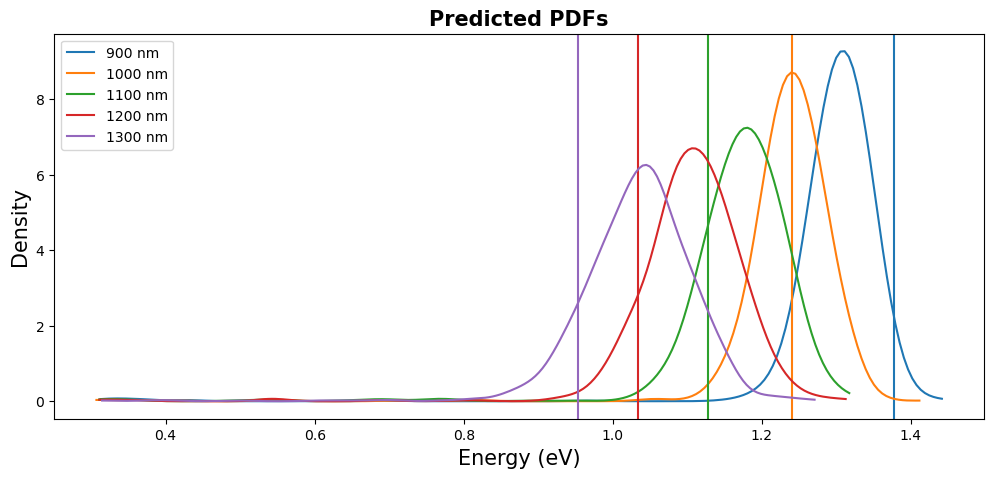

In [27]:
#Plotting Histograms
fig, ax = plt.subplots(len(eval_dict_storage),1, figsize = (12,5*len(eval_dict_storage)))
fig.tight_layout(pad=4.0)

i = 0
for eval_dict in eval_dict_storage:    

    #Plotting Model Predictions Histograms
    R_pred = eval_dict['pred_E_Res'][0]
    ax[i].hist(eval_dict['pred_hist'], bins = 200, density = True)
    ax[i].plot(eval_dict['plot_pred_x'], eval_dict['plot_pred_pdf'], label =  f"R: {R_pred:.3f}")
    ax[i].axvline(1.24e3/eval_dict['wavelength'], color = 'red')
    ax[i].set_ylabel("Density", fontsize = 15)
    ax[i].set_xlabel("Energy (eV)", fontsize = 15)
    ax[i].set_title("Predicted " + str(eval_dict['wavelength']) + " nm Photon Energy Histogram", fontweight = 'bold', fontsize = 15)
    ax[i].legend()

   
    i += 1

plt.show()

#Overplotting All PDFs
i=0
plt.figure(figsize = (12,5))
for eval_dict in eval_dict_storage:
    plt.plot(eval_dict['plot_pred_x'], eval_dict['plot_pred_pdf'], color = "C"+ str(i), label = str(eval_dict['wavelength']) + " nm")
    plt.axvline(1.24e3/eval_dict['wavelength'], color = "C"+ str(i))
    i += 1
  
plt.ylabel("Density", fontsize = 15)
plt.xlabel("Energy (eV)", fontsize = 15)
plt.title("Predicted PDFs", fontweight = 'bold', fontsize = 15)
plt.legend()
plt.show()